# **1st Hackathon: Kaggle Competition - Restaurant Visitor Forecasting**
<hr>

<br>

## **목차**

1. 데이터 통합 및 탐색(Data Integration and EDA)
2. 데이터 전처리 및 FE(Data Preprocessing and Feature Engineering)
4. 모델 설계 및 학습(Model Design and Training)
5. 평가 및 회고(Evaluation)






## **Competition Overview**

- [Recruit Restaurant Visitor Forecasting Competition](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/overview)
- Sponsored by Recruit Holings.
- Held in Jan. 2018.
- Challenged to use reservation and visitation data **to predict the total number of visiotrs to a restaurant for future dates**.
- Will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

<br>

#### - Submission & Evaluation
- Submissions are **evaluated on the root mean squared logarithmic error(RMSLE)**.
- Submission file should contain two columns: **id** and **visiotrs**.
    - id: Formed by concatenating the **air_store_id** and **visit_date** with an underscore.
    - Should contain a header.

#### - Baseline Kernal
- [Johannesss's Multiple Light GBM](https://www.kaggle.com/johannesss/multiple-lightgbm)

<br>

## **1. 데이터 통합 및 탐색**

In [81]:
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import Image
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

from sklearn import model_selection, ensemble, neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from subprocess import check_output

import xgboost as xgb
import lightgbm as lgb

In [82]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# Load dataset
dir_path = 'drive/My Drive/Colab Notebooks/Hackerthon1_210804/input'

data = {
    'tra': pd.read_csv(dir_path + '/air_visit_data.csv'),
    'as': pd.read_csv(dir_path + '/air_store_info.csv'),
    'hs': pd.read_csv(dir_path + '/hpg_store_info.csv'),
    'ar': pd.read_csv(dir_path + '/air_reserve.csv'),
    'hr': pd.read_csv(dir_path + '/hpg_reserve.csv'),
    'id': pd.read_csv(dir_path + '/store_id_relation.csv'),
    'tes': pd.read_csv(dir_path + '/sample_submission.csv'),
    'hol': pd.read_csv(dir_path + '/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

for d in data:
  print(f"shape of {d}: {data[d].shape}")

shape of tra: (252108, 3)
shape of as: (829, 5)
shape of hs: (4690, 5)
shape of ar: (92378, 4)
shape of hr: (2000320, 4)
shape of id: (150, 2)
shape of tes: (32019, 2)
shape of hol: (517, 3)


### **1-1. 데이터셋 미리보기**

가장 데이터가 많은 3개 파일을 살펴본다.

In [84]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [85]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [86]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


### **1-2. 결측치 확인**

- 데이터셋의 각 컬럼별 결측치 개수를 확인해 보았다.
- 확인 결과 결측치 개수는 모두 0으로, 추가 처리가 필요하지 않았다.

In [87]:
# 각 파일의 column별 결측치 개수 확인하기
# Check missing values for each columns for each files
for d in data:
  for c in data[d].columns:
    print('{} : {}'.format(c, data[d][c].isna().sum()))

air_store_id : 0
visit_date : 0
visitors : 0
air_store_id : 0
air_genre_name : 0
air_area_name : 0
latitude : 0
longitude : 0
hpg_store_id : 0
hpg_genre_name : 0
hpg_area_name : 0
latitude : 0
longitude : 0
air_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
hpg_store_id : 0
visit_datetime : 0
reserve_datetime : 0
reserve_visitors : 0
air_store_id : 0
hpg_store_id : 0
id : 0
visitors : 0
visit_date : 0
day_of_week : 0
holiday_flg : 0


### **1-3. 데이터셋 통합 & 탐색**

- 데이터셋에 대한 이해를 높이기 위해 여러 가지 방법으로 탐색을 시도해 보았다.
- 이를 위해 우선 데이터셋을 통합하였다.
- 데이터 통합 순서는 다음 이미지와 같다.

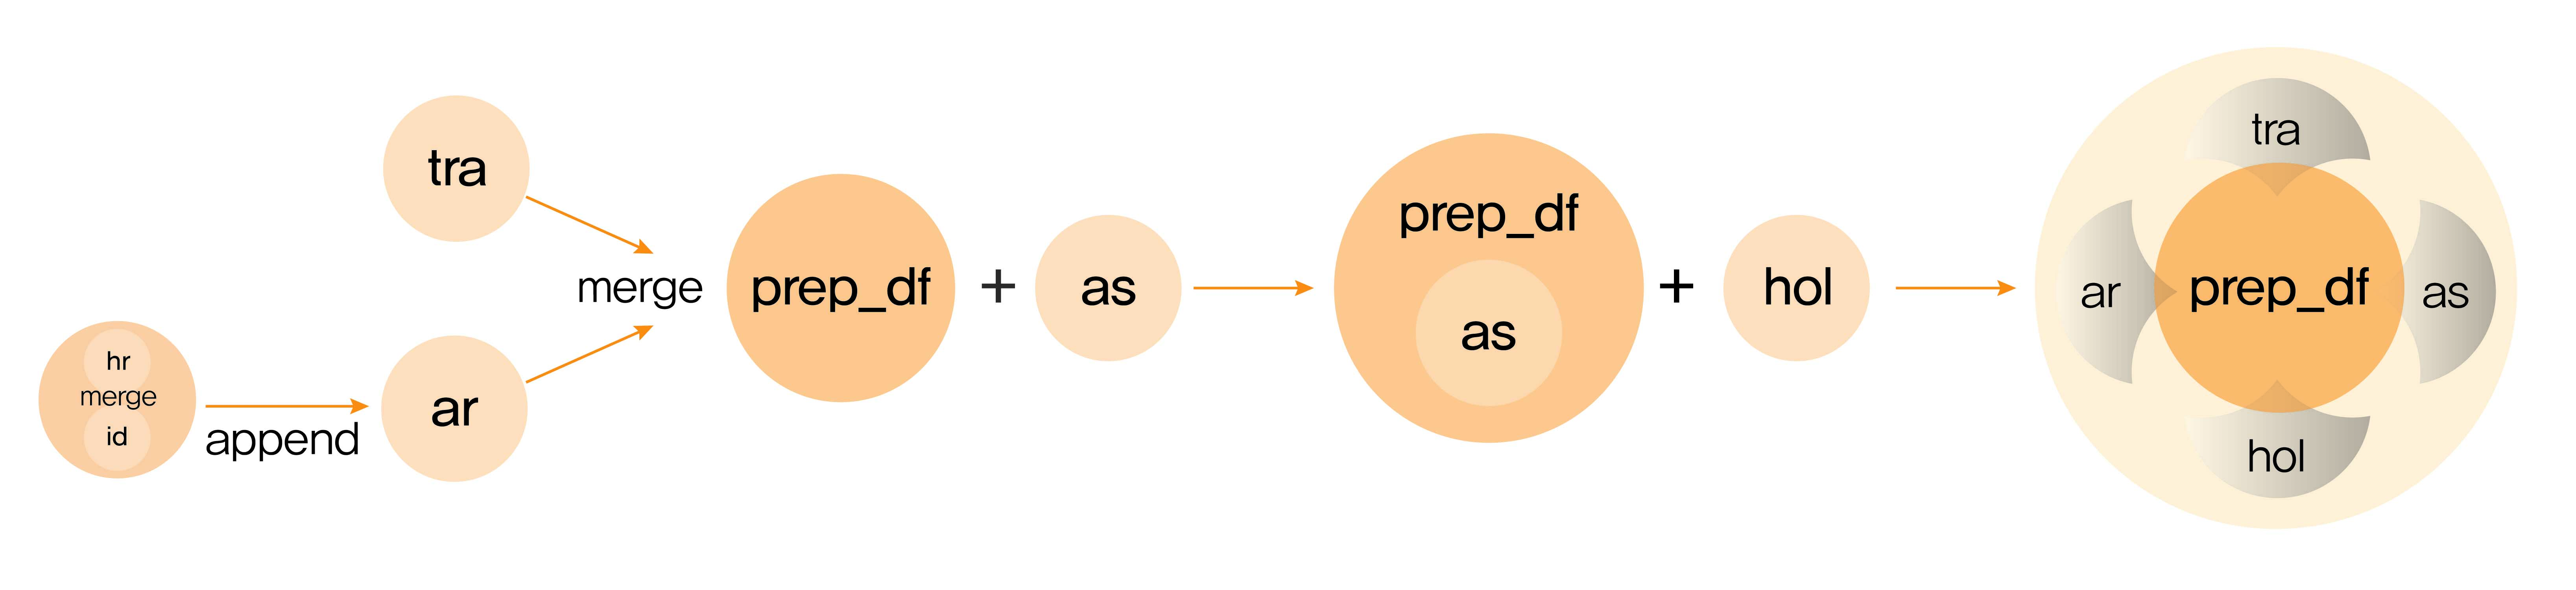

In [88]:
img_path = 'drive/My Drive/Colab Notebooks/Hackerthon1_210804/image/data_integration.jpg'
Image(img_path)

- 데이터 통합 후, 아래 기간의 train 데이터셋을 통해 test 기간의 visitors 수를 예측한다.

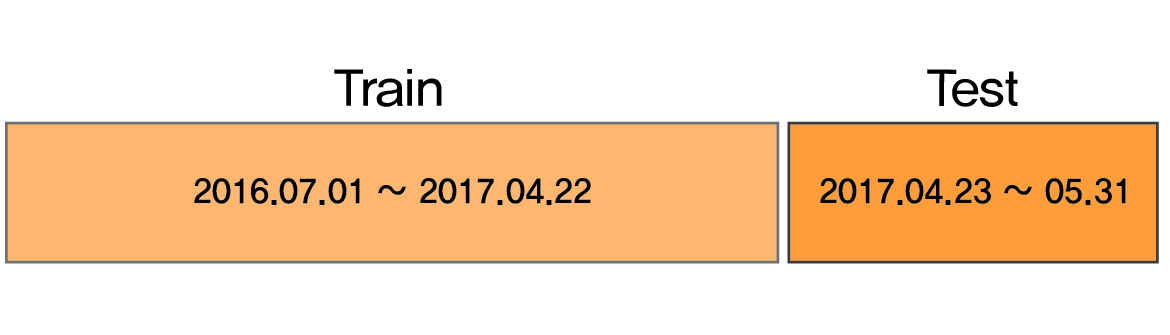

In [89]:
img_path = 'drive/My Drive/Colab Notebooks/Hackerthon1_210804/image/train_test.jpg'
Image(img_path, width=500)

#### **1) store_id 통일**

- 최종 output은 air_store_id를 기준으로 한다.
- hpg_store_id는 store_id_relation.csv을 기준으로 air_store_id로 변경하여 통일해 주었다.
- merge 방법은 inner로 하여 교집합에 해당하는 store만 고려하였다.

In [90]:
# hpg_store_id를 기준으로 air_store 데이터와 통합
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

# 최종 output은 air_store_id가 기준이 되므로 hpg_store_id는 drop해서 id를 통일
data['hr'].drop('hpg_store_id',  axis=1, inplace=True)

data['hr'].head()

,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


In [91]:
print("air_reserve:", data['ar'].shape)

# air_reserve에 hpg_reserve 데이터를 추가
data['ar'] = data['ar'].append(data['hr'])

print("total_reserve:", data['ar'].shape)

air_reserve: (92378, 4)
total_reserve: (120561, 4)


#### **2) date & datetime 통일**

- visit 또는 reserve date과 datetime column을 생성하여 통일한다.
- pd.to_datetime, dt 등을 이용해 데이터 타입을 변환하여 통일한다.

In [92]:
# 기존 visitor 데이터에 datetime column을 추가
data['tra']['visit_datetime'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['visit_date'] = data['tra']['visit_datetime'].dt.date

# 방문 요일을 column으로 추가
data['tra']['dow'] = data['tra']['visit_datetime'].dt.dayofweek

data['tra'].head()

,air_store_id,visit_date,visitors,visit_datetime,dow
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,2
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,3
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,4
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,5
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,0


In [93]:
# datetime 타입으로 변환
data['ar']['visit_datetime'] = pd.to_datetime(data['ar']['visit_datetime'])

# visite_date column 추가 및 타입 변환
data['ar']['visit_date'] = data['ar']['visit_datetime'].dt.date

In [94]:
# 불필요한 column 삭제
data['ar'].drop('visit_datetime', axis=1, inplace=True)
data['ar'].drop('reserve_datetime', axis=1, inplace=True)

In [95]:
# store_id와 date를 기준으로 방문 예정 인원 합치기
data['ar'] = data['ar'].groupby(['air_store_id','visit_date'], as_index=False).sum().reset_index()

# index 열은 중복되므로 삭제
data['ar'] = data['ar'].drop(['index'], axis=1)

data['ar'].head()

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,2
1,air_00a91d42b08b08d9,2016-01-15,4
2,air_00a91d42b08b08d9,2016-01-16,2
3,air_00a91d42b08b08d9,2016-01-22,2
4,air_00a91d42b08b08d9,2016-01-29,5


In [96]:
# datetime 타입으로 변환
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])

# str 타입으로 다시 변환
data['hol']['visit_date'] = data['hol']['visit_date'].astype(str)

data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


#### **3) test 데이터셋 column 통일**

- train 데이터셋과 동일한 형태로 맞추기 위해 test 데이터셋의 column을 변환하고 통합한다.

In [97]:
data['tes'].head()

# id를 store_id와 date로 분리
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])

# 최종 output은 기존 id column 형태가 필요하므로 변수에 따로 저장
test_id = data['tes']['id']

# 기존 id column을 drop
data['tes'].drop('id', axis=1, inplace=True)

# 출력해서 확인
data['tes'].head()

,visitors,air_store_id,visit_date
0,0,air_00a91d42b08b08d9,2017-04-23
1,0,air_00a91d42b08b08d9,2017-04-24
2,0,air_00a91d42b08b08d9,2017-04-25
3,0,air_00a91d42b08b08d9,2017-04-26
4,0,air_00a91d42b08b08d9,2017-04-27


In [98]:
# datetime과 dow column 생성
data['tes']['visit_datetime'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_datetime'].dt.dayofweek

<br>

#### **4) date와 day_of_week에 따른 visitor 탐색**

- 날짜와 요일에 따른 전체 visitor 수를 visualize해서 살펴 보았다.
- 날짜에 따른 visitor의 경우, **2016년 7월부터 전체 visitor 수가 크게 증가**한 것으로 보아, 데이터 수집 방식이나 환경에 변화가 있었던 것으로 보인다. **추후 데이터 전처리 과정에서 before 2016년 7월인 데이터는 exclude**하기로 결정하였다.
- 2017년 1월쯤 유독 visitor 수가 적다. 해당 기간의 데이터를 이상치로 판단할 수도 있지만, 그에 상응하는 2016년 1월 데이터를 사실상 알 수 없기 때문에 이상치라고 판단할 근거가 부족하다. 따라서 그냥 포함시키기로 하였다.

<br>

- 요일에 따른 visitor의 경우, 역시 금요일과 토요일에 가장 visitor가 많은 것으로 나타났다.
- 0~6은 순서대로 월요일부터 일요일까지를 의미한다.

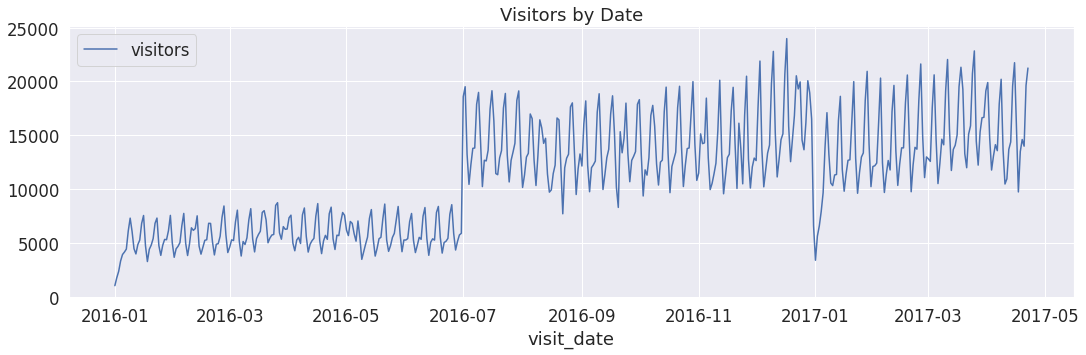

In [99]:
# 날짜에 따른 전체 visitor 시각화해서 살펴보기
_tmp1 = data['tra'].copy()

# 요일별 visitor 시각화를 위해 데이터 저장해두기
_tmp_dow = data['tra'].copy()

# 불필요한 column drop
_tmp1.drop('dow',axis=1, inplace=True)

# visit_date을 기준으로 visitor 합계 계산
visitors_by_date = _tmp1.groupby('visit_date').sum()

ax = visitors_by_date.plot(figsize=[18,5], title='Visitors by Date')

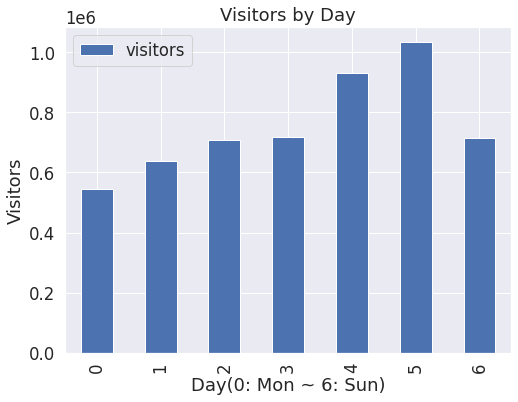

In [100]:
# 요일별 visitor 시각화해서 살펴보기
# 불필요한 columns drop
_tmp_dow.drop(['air_store_id', 'visit_date', 'visit_datetime'], axis=1, inplace=True)

visitors_by_day = _tmp_dow.groupby('dow').sum()

ax = visitors_by_day.plot.bar(xlabel='Day(0: Mon ~ 6: Sun)', ylabel='Visitors', title='Visitors by Day', figsize=(8, 6))

<br>

#### **5) 나머지 데이터셋 통합**

##### **5-1) visitor, reserve, store information, holiday 정보 통합**

In [101]:
# visitor와 reserve, store information, holiday 관련 데이터 대통합
prep_df = pd.merge(data['tra'], data['ar'], how='left', on=['air_store_id', 'visit_date'])
prep_df = pd.merge(prep_df, data['as'], how='inner', on='air_store_id')
prep_df = pd.merge(prep_df, data['hol'], how='left', on='visit_date')

In [102]:
# test 데이터셋도 동일하게 처리
predict_data = pd.merge(data['tes'], data['ar'], how='left', on=['air_store_id', 'visit_date'])
predict_data = pd.merge(predict_data, data['as'], how='inner', on='air_store_id')
predict_data = pd.merge(predict_data, data['hol'], how='left', on='visit_date')

In [103]:
prep_df.head()

,air_store_id,visit_date,visitors,visit_datetime,dow,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,2,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,3,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,4,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,2016-01-16,5,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,2016-01-18,0,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN


<br>

##### **5-2) feature간 상관 관계 분석**


- 전체 데이터셋을 통합한 기념으로 간단하게 feature들 간의 상관 관계를 분석해 보았다.
- 본격적인 데이터 전처리 및 FE 전에 상관 관계를 분석해 봄으로써, 인사이트를 얻고 더 유의미한 feature에 집중할 수 있다.

In [104]:
# 주요 변수들 간의 상관 계수 확인
prep_df.corr()

,visitors,dow,reserve_visitors,latitude,longitude,holiday_flg
visitors,1.000000,0.175660,0.416142,0.000018,-0.007328,NaN
dow,0.175660,1.000000,0.104684,0.001297,-0.010168,NaN
reserve_visitors,0.416142,0.104684,1.000000,0.061333,0.000030,NaN
latitude,0.000018,0.001297,0.061333,1.000000,0.652447,NaN
longitude,-0.007328,-0.010168,0.000030,0.652447,1.000000,NaN
holiday_flg,NaN,NaN,NaN,NaN,NaN,NaN


<br>

- 데이터 병합 과정에서 **reserve_visitors와 holiday_flg 데이터에 missing value가 발생**하였다.
- **reserve_visitors의 경우, visitor 수를 예측하는 데 있어 예약자 수가 중요한 feature일 것으로 판단**하였고, **전처리 과정에서 결측치를 채우기로 하였다.**
- **holiday_flg의 경우 전체 데이터가 약 500개 정도로, train 데이터셋 20만 개와 비교하면 매우 적어서 column을 drop**시키기로 하였다.

##### **5-3) 그 외 궁금한 부분 탐색**

- 예약은 했지만 방문하지 않은 경우가 있는지 확인해 보았다. 결과적으로는 없었다.

In [105]:
# visitor가 0인 경우가 있는지 확인 == no-show가 있는지 확인
no_show = prep_df['visitors'].apply(lambda x: x == 0).sum()

print("no-show: ", no_show)

no-show:  0


<hr>
<br>

## **2. 데이터 전처리 및 FE**

### **2-1. 2016년 7월 이전 데이터 제외하기**

- 앞서 날짜별 visitors 수에 관한 데이터 탐색 결과, 대략 2016년 7월 이전 데이터를 제외하기로 결정하였다.

In [106]:
# 2016년 7월부터의 데이터만 사용한다
# Using data 'visit_date' after '2016-07-01'
prep_df['visit_date'] = prep_df['visit_date'].astype(str)
prep_df = prep_df[prep_df['visit_date'] >= '2016-07-01']

In [107]:
# store_id와 visit_date를 기준으로 데이터프레임 정렬
prep_df['visit_date'] = pd.to_datetime(prep_df['visit_date']).dt.date
prep_df.sort_values(by=['air_store_id', 'visit_date'])

prep_df.head()

,air_store_id,visit_date,visitors,visit_datetime,dow,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
140,air_ba937bf13d40fb24,2016-07-01,61,2016-07-01,4,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
141,air_ba937bf13d40fb24,2016-07-02,25,2016-07-02,5,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
142,air_ba937bf13d40fb24,2016-07-04,21,2016-07-04,0,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
143,air_ba937bf13d40fb24,2016-07-05,24,2016-07-05,1,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN
144,air_ba937bf13d40fb24,2016-07-06,19,2016-07-06,2,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN


In [108]:
prep_df.tail()

,air_store_id,visit_date,visitors,visit_datetime,dow,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
252103,air_24e8414b9b07decb,2017-04-18,6,2017-04-18,1,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,NaN,NaN
252104,air_24e8414b9b07decb,2017-04-19,6,2017-04-19,2,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,NaN,NaN
252105,air_24e8414b9b07decb,2017-04-20,7,2017-04-20,3,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,NaN,NaN
252106,air_24e8414b9b07decb,2017-04-21,8,2017-04-21,4,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,NaN,NaN
252107,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,5,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,NaN,NaN


### **2-2. reserve_visitors 결측치 처리**

- 앞서 데이터 통합 및 탐색 과정에서 reserve_visitors 데이터에 missing value가 발생한 것을 확인하였다.
- **결측치 처리 과정**
    - 1) 적절한 값으로 결측치를 채우기 위해, 우선 현재 reserve_visitors 데이터의 분포를 확인해 보았다.
    - 2) **reserve_visitors 데이터의 이상치 outlier를 탐치 및 제거**하였다.
    - 3) **날짜별 visitor와 reserve_visitors의 비율의 평균을 구해 결측치를 보완**하였다.

#### **1) reserve_visitor 데이터 분포 확인**

In [109]:
# Check numbers of missing values
print("reserve_visitors 결측치 개수: ", prep_df['reserve_visitors'].isna().count())
print("reserve_visitors 데이터 개수: ", prep_df['reserve_visitors'].count())

reserve_visitors 결측치 개수:  204409
reserve_visitors 데이터 개수:  29275


In [110]:
# visitors 데이터 분포 확인
prep_df['visitors'].describe()

count    204409.000000
mean         20.780841
std          16.673307
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

In [111]:
# reserve_visitors 데이터 분포 확인
prep_df['reserve_visitors'].describe()

count    29275.000000
mean        13.646627
std         18.068294
min          1.000000
25%          4.000000
50%          9.000000
75%         18.000000
max       1633.000000
Name: reserve_visitors, dtype: float64

In [112]:
# 결측치를 제외한 데이터를 res_vis_df에 저장하여 분포를 확인
res_vis_df = prep_df[prep_df['reserve_visitors'].isna() == False]

# 불필요한 column drop
res_vis_df.drop(['air_store_id'], axis=1, inplace=True)
res_vis_df.drop(['visit_datetime'], axis=1, inplace=True)
res_vis_df.drop(['dow'], axis=1, inplace=True)
res_vis_df.drop(['air_genre_name'], axis=1, inplace=True)
res_vis_df.drop(['air_area_name'], axis=1, inplace=True)
res_vis_df.drop(['latitude'], axis=1, inplace=True)
res_vis_df.drop(['longitude'], axis=1, inplace=True)
res_vis_df.drop(['day_of_week'], axis=1, inplace=True)
res_vis_df.drop(['holiday_flg'], axis=1, inplace=True)

res_vis_df.head()

,visit_date,visitors,reserve_visitors
3989,2016-10-30,33,15.0
3990,2016-10-31,9,1.0
3991,2016-11-01,20,2.0
3993,2016-11-03,36,6.0
3994,2016-11-05,21,8.0


In [113]:
# res_vis_df의 reserve_visitors 데이터 분포 확인
res_vis_df['reserve_visitors'].describe()

count    29275.000000
mean        13.646627
std         18.068294
min          1.000000
25%          4.000000
50%          9.000000
75%         18.000000
max       1633.000000
Name: reserve_visitors, dtype: float64

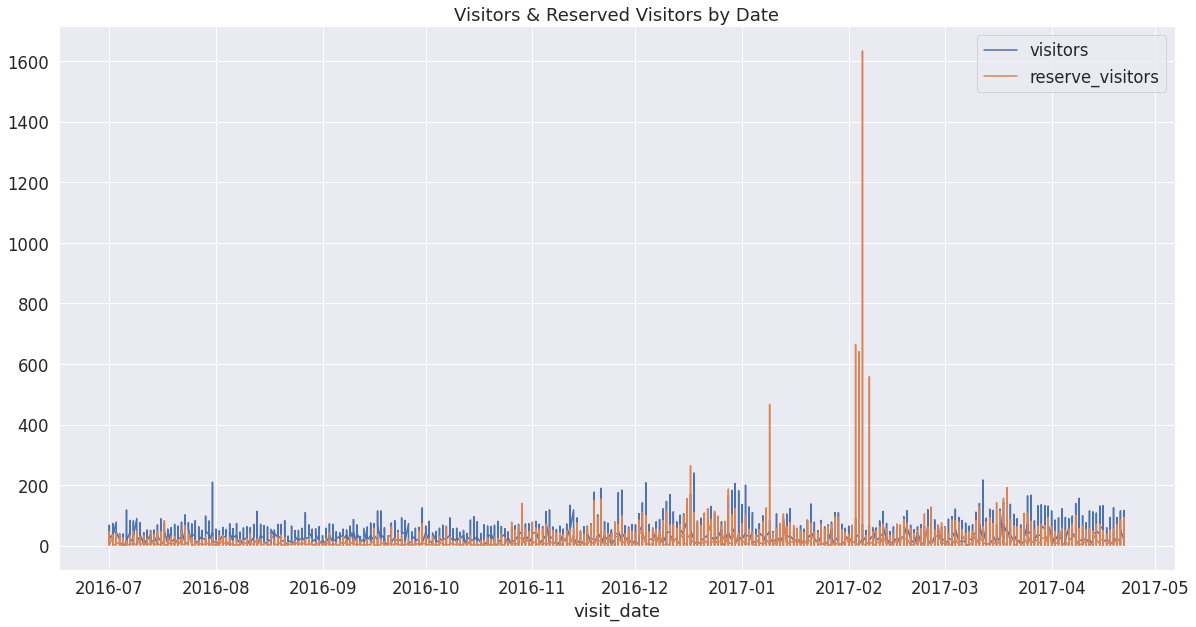

In [114]:
# 시각화해서 확인해보기
res_vis_df.plot(x='visit_date', figsize=(20, 10), title='Visitors & Reserved Visitors by Date')

#### **2) reserve_visitors 데이터 이상치 outliers 탐지 및 제거**

- boxplot을 그려 데이터 분포와 이상치를 확인하였다.
- **reserve_visitors가 200 이상인 데이터를 이상치로 간주하여 삭제**하기로 결정하였다.

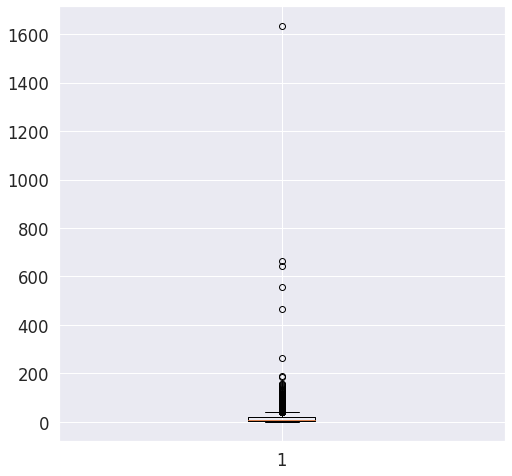

In [115]:
# 이상치 판단을 위해 boxplot 그려보기
plt.figure(figsize=(8, 8))
plt.boxplot(res_vis_df['reserve_visitors'])
plt.show()

In [116]:
# reserve_visitors가 200 이상인 데이터를 조회한다
trim_df = prep_df[prep_df['reserve_visitors'] >= 200]

trim_df

,air_store_id,visit_date,visitors,visit_datetime,dow,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
8845,air_7514d90009613cd6,2016-12-17,170,2016-12-17,5,264.0,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,NaN,NaN
17041,air_e7fbee4e3cfe65c5,2017-02-03,33,2017-02-03,4,664.0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,NaN,NaN
17042,air_e7fbee4e3cfe65c5,2017-02-04,56,2017-02-04,5,641.0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,NaN,NaN
17043,air_e7fbee4e3cfe65c5,2017-02-05,18,2017-02-05,6,1633.0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,NaN,NaN
17044,air_e7fbee4e3cfe65c5,2017-02-07,27,2017-02-07,1,557.0,Izakaya,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,37.916367,139.036327,NaN,NaN
68051,air_465bddfed3353b23,2017-01-09,30,2017-01-09,0,466.0,Dining bar,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,NaN,NaN


In [117]:
# 위 데이터들을 prep_df에서 제거
prep_df.drop(index=[8845, 17041, 17042, 17043, 17044, 68051], axis=1, inplace=True)

prep_df.describe()

,visitors,dow,reserve_visitors,latitude,longitude,holiday_flg
count,204403.000000,204403.000000,29269.000000,204403.000000,204403.000000,0.0
mean,20.779817,3.025968,13.505074,35.634900,137.382740,NaN
std,16.670062,1.924704,13.776621,2.076340,3.661574,NaN
min,1.000000,0.000000,1.000000,33.211967,130.195555,NaN
25%,9.000000,1.000000,4.000000,34.695124,135.341564,NaN
50%,17.000000,3.000000,9.000000,35.658068,139.671958,NaN
75%,29.000000,5.000000,18.000000,35.694003,139.751599,NaN
max,877.000000,6.000000,191.000000,44.020632,144.273398,NaN


#### **3) 결측치 보완**

- 날짜별 visitors와 reserve_visitors 비율의 평균을 구한다.
- 즉 예약 인원과 방문 인원의 평균 비율로 visitors에 따른 reserve_visitors 값을 추측한다.
- 해당 값으로 NaN을 대체한다.



In [118]:
# 날짜별 visitors와 reserve_visitors 비율의 평균 계산
avg_vis_rate = prep_df[prep_df['reserve_visitors'].isna() == False].apply(lambda x: x['reserve_visitors'] / x['visitors'], axis=1).mean()

print("visitros와 reserve_visitors 평균 비율:", avg_vis_rate)

visitros와 reserve_visitors 평균 비율: 0.6060166420159571


In [119]:
# avg_vis_rate을 이용해 모든 visitors 데이터에 대한 평균 reserve_visitors 데이터를 생성
avg_rev_visitors = prep_df.apply(lambda x: x['visitors'] * avg_vis_rate if pd.isna(x['reserve_visitors']) == True else x['reserve_visitors'], axis=1)

avg_rev_visitors.describe()

count    204403.000000
mean         12.173985
std          10.455670
min           0.606017
25%           4.848133
50%           9.696266
75%          16.968466
max         531.476595
dtype: float64

In [120]:
# avg_rev_visitors를 prep_df의 column으로 추가
prep_df['avg_rev_visitors'] = avg_rev_visitors

# 기존 reserve_visitors column drop
prep_df.drop('reserve_visitors', axis=1, inplace=True)

prep_df.head()

,air_store_id,visit_date,visitors,visit_datetime,dow,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,avg_rev_visitors
140,air_ba937bf13d40fb24,2016-07-01,61,2016-07-01,4,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,36.967015
141,air_ba937bf13d40fb24,2016-07-02,25,2016-07-02,5,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,15.150416
142,air_ba937bf13d40fb24,2016-07-04,21,2016-07-04,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,12.726349
143,air_ba937bf13d40fb24,2016-07-05,24,2016-07-05,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,14.544399
144,air_ba937bf13d40fb24,2016-07-06,19,2016-07-06,2,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,11.514316


In [121]:
# test dataset에도 동일하게 처리
# avg_vis_rate을 이용해 모든 visitors 데이터에 대한 평균 reserve_visitors 데이터를 생성
avg_rev_visitors = predict_data.apply(lambda x: x['visitors'] * avg_vis_rate if pd.isna(x['reserve_visitors']) == True else x['reserve_visitors'], axis=1)

# avg_rev_visitors를 prep_df의 column으로 추가
predict_data['avg_rev_visitors'] = avg_rev_visitors

# 기존 reserve_visitors column drop
predict_data.drop('reserve_visitors', axis=1, inplace=True)

predict_data.head()

,visitors,air_store_id,visit_date,visit_datetime,dow,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,avg_rev_visitors
0,0,air_00a91d42b08b08d9,2017-04-23,2017-04-23,6,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,0,0.0
1,0,air_00a91d42b08b08d9,2017-04-24,2017-04-24,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Monday,0,0.0
2,0,air_00a91d42b08b08d9,2017-04-25,2017-04-25,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tuesday,0,0.0
3,0,air_00a91d42b08b08d9,2017-04-26,2017-04-26,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Wednesday,0,0.0
4,0,air_00a91d42b08b08d9,2017-04-27,2017-04-27,3,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Thursday,0,0.0


### **2-3. holiday_flg feature drop**

In [122]:
prep_df.drop('holiday_flg', axis=1, inplace=True)
predict_data.drop('holiday_flg', axis=1, inplace=True)

### **2-4. visitors 통계값을 이용한 feature 추가**

In [123]:
# store_id와 요일별 visitors 최소값을 column에 추가
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].min().rename(columns={'visitors': 'min_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])

# store_id와 요일별 visitors 평균값을 column에 추가
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].mean().rename(columns={'visitors': 'mean_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])

# store_id와 요일별 visitors 중간값을 column에 추가
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].median().rename(columns={'visitors': 'median_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])

# store_id와 요일별 visitors 최대값을 column에 추가
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].max().rename(columns={'visitors': 'max_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])

In [124]:
prep_df.head()

,air_store_id,visit_date,visitors,visit_datetime,dow,air_genre_name,air_area_name,latitude,longitude,day_of_week,avg_rev_visitors,min_visitors,mean_visitors,median_visitors,max_visitors
0,air_ba937bf13d40fb24,2016-07-01,61,2016-07-01,4,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,36.967015,4,34.738462,35.0,61
1,air_ba937bf13d40fb24,2016-07-02,25,2016-07-02,5,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,15.150416,6,27.651515,27.0,53
2,air_ba937bf13d40fb24,2016-07-04,21,2016-07-04,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,12.726349,2,13.754386,12.0,34
3,air_ba937bf13d40fb24,2016-07-05,24,2016-07-05,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,14.544399,5,18.580645,19.0,35
4,air_ba937bf13d40fb24,2016-07-06,19,2016-07-06,2,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,11.514316,7,23.843750,25.0,57


In [125]:
# store_id와 요일별 reserve_visitors 평균값을 column에 추가
tmp = prep_df.groupby(['air_store_id', 'dow'], as_index=False)['avg_rev_visitors'].mean().rename(columns={'visitors': 'mean_rev_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])

prep_df.head()

,air_store_id,visit_date,visitors,visit_datetime,dow,air_genre_name,air_area_name,latitude,longitude,day_of_week,avg_rev_visitors_x,min_visitors,mean_visitors,median_visitors,max_visitors,avg_rev_visitors_y
0,air_ba937bf13d40fb24,2016-07-01,61,2016-07-01,4,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,36.967015,4,34.738462,35.0,61,20.142839
1,air_ba937bf13d40fb24,2016-07-02,25,2016-07-02,5,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,15.150416,6,27.651515,27.0,53,16.679887
2,air_ba937bf13d40fb24,2016-07-04,21,2016-07-04,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,12.726349,2,13.754386,12.0,34,7.497292
3,air_ba937bf13d40fb24,2016-07-05,24,2016-07-05,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,14.544399,5,18.580645,19.0,35,11.165857
4,air_ba937bf13d40fb24,2016-07-06,19,2016-07-06,2,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,11.514316,7,23.843750,25.0,57,13.862631


In [126]:
prep_df.drop('avg_rev_visitors_x', axis=1, inplace=True)
predict_data.drop('avg_rev_visitors_x', axis=1, inplace=True)

predict_data.head()

,visitors,air_store_id,visit_date,visit_datetime,dow,air_genre_name,air_area_name,latitude,longitude,day_of_week,min_visitors,mean_visitors,median_visitors,max_visitors,avg_rev_visitors_y
0,0,air_00a91d42b08b08d9,2017-04-23,2017-04-23,6,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,2.0,2.000000,2.0,2.0,1.212033
1,0,air_00a91d42b08b08d9,2017-04-24,2017-04-24,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Monday,1.0,22.457143,19.0,47.0,12.877926
2,0,air_00a91d42b08b08d9,2017-04-25,2017-04-25,1,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tuesday,1.0,24.350000,24.5,43.0,11.492433
3,0,air_00a91d42b08b08d9,2017-04-26,2017-04-26,2,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Wednesday,15.0,28.125000,28.0,52.0,13.663637
4,0,air_00a91d42b08b08d9,2017-04-27,2017-04-27,3,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Thursday,15.0,29.868421,30.0,47.0,14.999837


In [127]:
# 불필요한 column drop
prep_df.drop('dow', axis=1, inplace=True)
predict_data.drop('dow', axis=1, inplace=True)

#### **- feature 상관 관계 시각화**

In [128]:
corr = prep_df.corr(method = 'pearson')

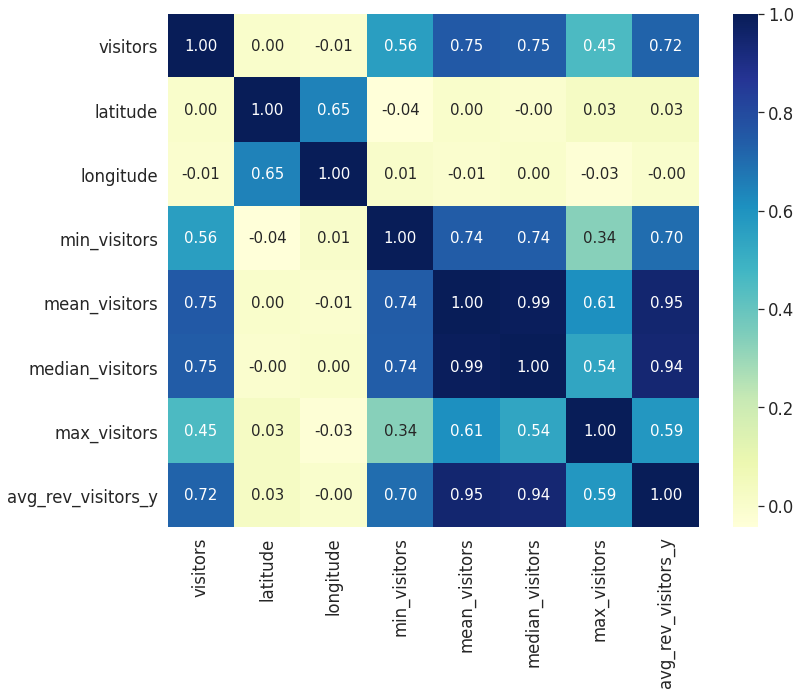

In [129]:
fig = plt.figure(figsize = (12, 10))
ax = fig.gca()
sns.set(font_scale = 1.5)

# heatmap으로 상관 관계 시각화
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15}, yticklabels = corr, xticklabels = corr, ax=ax, cmap = "YlGnBu")

plt.tight_layout()
plt.show()

### **2-5. 범주형 데이터 라벨 인코딩**

#### **1) 날짜 데이터 라벨 인코딩**

In [130]:
# visit_datetime을 month, day로 나눠서 column으로 추가
# train 데이터셋
prep_df['month'] = prep_df['visit_datetime'].dt.month
prep_df['day'] = prep_df['visit_datetime'].dt.day
prep_df.drop('visit_datetime', axis=1, inplace=True)   

# test 데이터셋
predict_data['month'] = predict_data['visit_datetime'].dt.month
predict_data['day'] = predict_data['visit_datetime'].dt.day
predict_data.drop('visit_datetime', axis=1, inplace=True)

#### **2) genre, area, day_of_week 데이터 라벨 인코딩**

In [131]:
new_features = [col for col in ['air_genre_name', 'air_area_name', 'day_of_week']]

for column in new_features:
    temp_prep = pd.get_dummies(pd.Series(prep_df[column]))
    prep_df = pd.concat([prep_df,temp_prep],axis=1)
    prep_df = prep_df.drop([column],axis=1)

    temp_predict = pd.get_dummies(pd.Series(predict_data[column]))
    predict_data = pd.concat([predict_data,temp_predict],axis=1)
    predict_data = predict_data.drop([column],axis=1)

    # train과 test 데이터셋의 column이 동일한지 확인
    for missing_col in temp_prep:     
        if missing_col not in predict_data.columns:
            predict_data[missing_col] = 0
            
    for missing_col in temp_predict:     
        if missing_col not in prep_df.columns:
            prep_df[missing_col] = 0        

#### **3) air_store_id 데이터 라벨 인코딩**

In [132]:
label_enc = preprocessing.LabelEncoder()

label_enc.fit(prep_df['air_store_id'])
prep_df['air_store_id'] = label_enc.transform(prep_df['air_store_id'])

prep_cols = prep_df.columns

In [133]:
predict_data.drop(['visit_date'], axis=1, inplace=True)  

predict_data['air_store_id'] = label_enc.transform(predict_data['air_store_id'])

In [134]:
prep_df.shape

(204403, 136)

### **2-6. 기타 결측치 확인 및 처리**

In [135]:
prep_df.head()

,air_store_id,visit_date,visitors,latitude,longitude,min_visitors,mean_visitors,median_visitors,max_visitors,avg_rev_visitors_y,month,day,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,Fukuoka-ken Fukuoka-shi Hakata Ekimae,Fukuoka-ken Fukuoka-shi Imaizumi,Fukuoka-ken Fukuoka-shi Momochi,Fukuoka-ken Fukuoka-shi Shiobaru,Fukuoka-ken Fukuoka-shi Takatori,Fukuoka-ken Fukuoka-shi Tenjin,Fukuoka-ken Fukuoka-shi Torikai,Fukuoka-ken Itoshima-shi Maebarunishi,Fukuoka-ken Kitakyūshū-shi Konyamachi,Fukuoka-ken Kitakyūshū-shi None,Fukuoka-ken Kitakyūshū-shi Ōtemachi,Fukuoka-ken Kurume-shi Jōnanmachi,Fukuoka-ken Yame-shi Motomachi,...,Tōkyō-to Setagaya-ku Setagaya,Tōkyō-to Shibuya-ku Dōgenzaka,Tōkyō-to Shibuya-ku Higashi,Tōkyō-to Shibuya-ku Jingūmae,Tōkyō-to Shibuya-ku Shibuya,Tōkyō-to Shinagawa-ku Higashigotanda,Tōkyō-to Shinagawa-ku Hiromachi,Tōkyō-to Shinjuku-ku Kabukichō,Tōkyō-to Shinjuku-ku Nishishinjuku,Tōkyō-to Suginami-ku Asagayaminami,Tōkyō-to Tachikawa-shi Izumichō,Tōkyō-to Taitō-ku Asakusa,Tōkyō-to Taitō-ku Higashiueno,Tōkyō-to Taitō-ku Kuramae,Tōkyō-to Toshima-ku Higashiikebukuro,Tōkyō-to Toshima-ku Mejiro,Tōkyō-to Toshima-ku Minamiikebukuro,Tōkyō-to Toshima-ku Nishiikebukuro,Tōkyō-to Toshima-ku Sugamo,Tōkyō-to Ōta-ku Kamata,Tōkyō-to Ōta-ku Kamiikedai,Ōsaka-fu Higashiōsaka-shi Aramotokita,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,603,2016-07-01,61,35.658068,139.751599,4,34.738462,35.0,61,20.142839,7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,603,2016-07-02,25,35.658068,139.751599,6,27.651515,27.0,53,16.679887,7,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,603,2016-07-04,21,35.658068,139.751599,2,13.754386,12.0,34,7.497292,7,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,603,2016-07-05,24,35.658068,139.751599,5,18.580645,19.0,35,11.165857,7,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,603,2016-07-06,19,35.658068,139.751599,7,23.843750,25.0,57,13.862631,7,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [136]:
# 각 column별 결측치 개수 확인하기
for col in prep_df.columns:
  print('{} : {}'.format(col, prep_df[col].isna().sum()))

air_store_id : 0
visit_date : 0
visitors : 0
latitude : 0
longitude : 0
min_visitors : 0
mean_visitors : 0
median_visitors : 0
max_visitors : 0
avg_rev_visitors_y : 0
month : 0
day : 0
Asian : 0
Bar/Cocktail : 0
Cafe/Sweets : 0
Creative cuisine : 0
Dining bar : 0
International cuisine : 0
Italian/French : 0
Izakaya : 0
Japanese food : 0
Karaoke/Party : 0
Okonomiyaki/Monja/Teppanyaki : 0
Other : 0
Western food : 0
Yakiniku/Korean food : 0
Fukuoka-ken Fukuoka-shi Daimyō : 0
Fukuoka-ken Fukuoka-shi Hakata Ekimae : 0
Fukuoka-ken Fukuoka-shi Imaizumi : 0
Fukuoka-ken Fukuoka-shi Momochi : 0
Fukuoka-ken Fukuoka-shi Shiobaru : 0
Fukuoka-ken Fukuoka-shi Takatori : 0
Fukuoka-ken Fukuoka-shi Tenjin : 0
Fukuoka-ken Fukuoka-shi Torikai : 0
Fukuoka-ken Itoshima-shi Maebarunishi : 0
Fukuoka-ken Kitakyūshū-shi Konyamachi : 0
Fukuoka-ken Kitakyūshū-shi None : 0
Fukuoka-ken Kitakyūshū-shi Ōtemachi : 0
Fukuoka-ken Kurume-shi Jōnanmachi : 0
Fukuoka-ken Yame-shi Motomachi : 0
Hiroshima-ken Fukuyama-shi Hig

In [137]:
# 각 column별 결측치 개수 확인하기
for col in predict_data.columns:
  print('{} : {}'.format(col, predict_data[col].isna().sum()))

visitors : 0
air_store_id : 0
latitude : 0
longitude : 0
min_visitors : 341
mean_visitors : 341
median_visitors : 341
max_visitors : 341
avg_rev_visitors_y : 365
month : 0
day : 0
Asian : 0
Bar/Cocktail : 0
Cafe/Sweets : 0
Creative cuisine : 0
Dining bar : 0
International cuisine : 0
Italian/French : 0
Izakaya : 0
Japanese food : 0
Karaoke/Party : 0
Okonomiyaki/Monja/Teppanyaki : 0
Other : 0
Western food : 0
Yakiniku/Korean food : 0
Fukuoka-ken Fukuoka-shi Daimyō : 0
Fukuoka-ken Fukuoka-shi Hakata Ekimae : 0
Fukuoka-ken Fukuoka-shi Imaizumi : 0
Fukuoka-ken Fukuoka-shi Momochi : 0
Fukuoka-ken Fukuoka-shi Shiobaru : 0
Fukuoka-ken Fukuoka-shi Takatori : 0
Fukuoka-ken Fukuoka-shi Tenjin : 0
Fukuoka-ken Fukuoka-shi Torikai : 0
Fukuoka-ken Itoshima-shi Maebarunishi : 0
Fukuoka-ken Kitakyūshū-shi Konyamachi : 0
Fukuoka-ken Kitakyūshū-shi None : 0
Fukuoka-ken Kitakyūshū-shi Ōtemachi : 0
Fukuoka-ken Kurume-shi Jōnanmachi : 0
Fukuoka-ken Yame-shi Motomachi : 0
Hiroshima-ken Fukuyama-shi Higashis

### **2-7. visitors generalization**

- 로그 변환을 통해 generalization

In [138]:
prep_df['visitors'] = np.log1p(prep_df['visitors'])

In [139]:
prep_df.drop(['visit_date'], axis=1, inplace=True)

### **2-8. train, test, label 데이터셋 생성**

In [140]:
X_train = prep_df.drop(['visitors'], axis=1)
y_train = prep_df['visitors'].values    
X_test = predict_data.drop(['visitors'], axis=1)

In [141]:
X_train.shape

(204403, 134)

In [142]:
X_train.head()

,air_store_id,latitude,longitude,min_visitors,mean_visitors,median_visitors,max_visitors,avg_rev_visitors_y,month,day,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,Fukuoka-ken Fukuoka-shi Hakata Ekimae,Fukuoka-ken Fukuoka-shi Imaizumi,Fukuoka-ken Fukuoka-shi Momochi,Fukuoka-ken Fukuoka-shi Shiobaru,Fukuoka-ken Fukuoka-shi Takatori,Fukuoka-ken Fukuoka-shi Tenjin,Fukuoka-ken Fukuoka-shi Torikai,Fukuoka-ken Itoshima-shi Maebarunishi,Fukuoka-ken Kitakyūshū-shi Konyamachi,Fukuoka-ken Kitakyūshū-shi None,Fukuoka-ken Kitakyūshū-shi Ōtemachi,Fukuoka-ken Kurume-shi Jōnanmachi,Fukuoka-ken Yame-shi Motomachi,Hiroshima-ken Fukuyama-shi Higashisakuramachi,Hiroshima-ken Hiroshima-shi Kokutaijimachi,...,Tōkyō-to Setagaya-ku Setagaya,Tōkyō-to Shibuya-ku Dōgenzaka,Tōkyō-to Shibuya-ku Higashi,Tōkyō-to Shibuya-ku Jingūmae,Tōkyō-to Shibuya-ku Shibuya,Tōkyō-to Shinagawa-ku Higashigotanda,Tōkyō-to Shinagawa-ku Hiromachi,Tōkyō-to Shinjuku-ku Kabukichō,Tōkyō-to Shinjuku-ku Nishishinjuku,Tōkyō-to Suginami-ku Asagayaminami,Tōkyō-to Tachikawa-shi Izumichō,Tōkyō-to Taitō-ku Asakusa,Tōkyō-to Taitō-ku Higashiueno,Tōkyō-to Taitō-ku Kuramae,Tōkyō-to Toshima-ku Higashiikebukuro,Tōkyō-to Toshima-ku Mejiro,Tōkyō-to Toshima-ku Minamiikebukuro,Tōkyō-to Toshima-ku Nishiikebukuro,Tōkyō-to Toshima-ku Sugamo,Tōkyō-to Ōta-ku Kamata,Tōkyō-to Ōta-ku Kamiikedai,Ōsaka-fu Higashiōsaka-shi Aramotokita,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,603,35.658068,139.751599,4,34.738462,35.0,61,20.142839,7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,603,35.658068,139.751599,6,27.651515,27.0,53,16.679887,7,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,603,35.658068,139.751599,2,13.754386,12.0,34,7.497292,7,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,603,35.658068,139.751599,5,18.580645,19.0,35,11.165857,7,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,603,35.658068,139.751599,7,23.843750,25.0,57,13.862631,7,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
X_test.head()

,air_store_id,latitude,longitude,min_visitors,mean_visitors,median_visitors,max_visitors,avg_rev_visitors_y,month,day,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,Fukuoka-ken Fukuoka-shi Hakata Ekimae,Fukuoka-ken Fukuoka-shi Imaizumi,Fukuoka-ken Fukuoka-shi Momochi,Fukuoka-ken Fukuoka-shi Shiobaru,Fukuoka-ken Fukuoka-shi Takatori,Fukuoka-ken Fukuoka-shi Tenjin,Fukuoka-ken Fukuoka-shi Torikai,Fukuoka-ken Itoshima-shi Maebarunishi,Fukuoka-ken Kitakyūshū-shi Konyamachi,Fukuoka-ken Kitakyūshū-shi None,Fukuoka-ken Kitakyūshū-shi Ōtemachi,Fukuoka-ken Kurume-shi Jōnanmachi,Fukuoka-ken Yame-shi Motomachi,Hiroshima-ken Fukuyama-shi Higashisakuramachi,Hiroshima-ken Hiroshima-shi Kokutaijimachi,...,Tōkyō-to Setagaya-ku Setagaya,Tōkyō-to Shibuya-ku Dōgenzaka,Tōkyō-to Shibuya-ku Higashi,Tōkyō-to Shibuya-ku Jingūmae,Tōkyō-to Shibuya-ku Shibuya,Tōkyō-to Shinagawa-ku Higashigotanda,Tōkyō-to Shinagawa-ku Hiromachi,Tōkyō-to Shinjuku-ku Kabukichō,Tōkyō-to Shinjuku-ku Nishishinjuku,Tōkyō-to Suginami-ku Asagayaminami,Tōkyō-to Tachikawa-shi Izumichō,Tōkyō-to Taitō-ku Asakusa,Tōkyō-to Taitō-ku Higashiueno,Tōkyō-to Taitō-ku Kuramae,Tōkyō-to Toshima-ku Higashiikebukuro,Tōkyō-to Toshima-ku Mejiro,Tōkyō-to Toshima-ku Minamiikebukuro,Tōkyō-to Toshima-ku Nishiikebukuro,Tōkyō-to Toshima-ku Sugamo,Tōkyō-to Ōta-ku Kamata,Tōkyō-to Ōta-ku Kamiikedai,Ōsaka-fu Higashiōsaka-shi Aramotokita,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,35.694003,139.753595,2.0,2.000000,2.0,2.0,1.212033,4,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,35.694003,139.753595,1.0,22.457143,19.0,47.0,12.877926,4,24,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,35.694003,139.753595,1.0,24.350000,24.5,43.0,11.492433,4,25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,35.694003,139.753595,15.0,28.125000,28.0,52.0,13.663637,4,26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,35.694003,139.753595,15.0,29.868421,30.0,47.0,14.999837,4,27,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## **3. 모델 설계 및 학습**

In [144]:
# 준비된 데이터 셋을 훈련용 x_train, y_train으로 분리
train_x = X_train.values
train_y = y_train

print(train_x.shape)
print(train_y.shape)

(204403, 134)
(204403,)


In [145]:
# 모델 학습용 train을 val셋으로 다시 분리하여 모델을 평가함
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=random_state)

eval_set=[(x_valid, y_valid)]

In [146]:
random_state = 2022

### - XGBoost Model

In [147]:
# xgboost 3가지 사용 xgboost의 수정할 수 있는 parameter들을 구분을 해서 3가지의 모델을 사용
xgboost1 = xgb.XGBRegressor(booster='gbtree', max_depth=6, n_estimators=200, learning_rate=0.02, num_iterations = 1000, random_state=random_state, alpha = 0, gamma = 0)
xgboost11 = xgb.XGBRegressor(booster='gbtree', max_depth=6, n_estimators=200, learning_rate=0.02, num_iterations = 1000, random_state=random_state, alpha = 0.8, gamma = 0.5)
xgboost2 = xgb.XGBRegressor(booster='gbtree', max_depth=7, n_estimators=200, learning_rate=0.015, num_iterations = 1000, random_state=random_state, alpha = 0, gamma = 0)
xgboost22 = xgb.XGBRegressor(booster='gbtree', max_depth=7, n_estimators=200, learning_rate=0.015, num_iterations = 1000, random_state=random_state, alpha = 0.3, gamma = 1)
xgboost3 = xgb.XGBRegressor(booster='gbtree', max_depth=8, n_estimators=200, learning_rate=0.03, num_iterations = 1000, random_state=random_state, alpha = 0, gamma = 0)
xgboost33 = xgb.XGBRegressor(booster='gbtree', max_depth=8, n_estimators=200, learning_rate=0.03, num_iterations = 1000, random_state=random_state, alpha = 1.5, gamma = 1.5)

### **- XGBoost Parameter**

- XGBoost
  - 여러개의 Descision Tree를 조합해서 사용하는 Ensemble 기법
- booster : 일반적으로 gbtree의 성능이 좋음
  - default : gbtree
- max_depth : 트리의 최대 깊이
  - default : 6
- n_estimators : 학습기 반복 개수
  - default : 100
  - 200이상부터는 학습의 진전이 적고 시간만 오래잡아먹음.
- learning_rate : 학습 단계 별 가중치 갱신 정도
  - default : 0.1
- gamma : 트리에서 가지를 더 나눌지 결정하는 최소 손실 값
  - default : 0
  - Overfitting문제 해결에 좋지만 너무 높을 경우 Underfitting이 생길 수 있음.
- alpha : 
  - default : 0
  - 불필요한 가중치를 0으로 만들어서 무시하도록함
  - Overfitting 방지에 도움이 됨

- eval : 손실 함수 회귀문제에서는 rmse를 일반적으로 사용

In [148]:
xgboost1.fit(train_x, train_y, eval_set=eval_set, eval_metric = "rmse", verbose = False, early_stopping_rounds=5)
xgboost11.fit(train_x, train_y, eval_set=eval_set, eval_metric = "rmse", verbose = False, early_stopping_rounds=5)
xgboost2.fit(train_x, train_y, eval_set=eval_set, eval_metric = "rmse", verbose = False, early_stopping_rounds=5)
xgboost22.fit(train_x, train_y, eval_set=eval_set, eval_metric = "rmse", verbose = False, early_stopping_rounds=5)
xgboost3.fit(train_x, train_y, eval_set=eval_set, eval_metric = "rmse", verbose = False, early_stopping_rounds=5)
xgboost33.fit(train_x, train_y, eval_set=eval_set, eval_metric = "rmse", verbose = False, early_stopping_rounds=5)

[12:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:47:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:55:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=1.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1.5,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, num_iterations=1000,
             objective='reg:linear', random_state=2022, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [149]:
# fit이 완료된 모델을 바탕으로 prediction 실행
# log scale 변환한 것을 다시 원래의 형태로 변환
test_pred1 = np.expm1(xgboost1.predict(X_test.values))
test_pred11 = np.expm1(xgboost11.predict(X_test.values))
test_pred2 = np.expm1(xgboost2.predict(X_test.values))
test_pred22 = np.expm1(xgboost22.predict(X_test.values))
test_pred3 = np.expm1(xgboost3.predict(X_test.values))
test_pred33 = np.expm1(xgboost33.predict(X_test.values))

In [150]:
# 세 모델에서 나온 예측 값의 평균을 최종 예상치로 사용
test_pred = (test_pred1 + test_pred11 + test_pred2 + test_pred22 + test_pred3 + test_pred33) / 6
# test_pred = (test_pred11 + test_pred22 + test_pred33) / 3

In [151]:
# 제출용 DataFrame에 넣어서 최종 제출본 완성
output_path = 'drive/My Drive/Colab Notebooks/restaurant_visitor_forecasting'

result = pd.DataFrame({"id": test_id, "visitors": test_pred})   
result.to_csv(output_path + '/6XGB_v4_sub.csv', index=False)
# result.to_csv(output_path + '/3XGB_v2_sub.csv', index=False)
print('Done')

Done


## **Evaluation**

- Best Scores
    - Public: 0.55757
    - Private: 0.51847

## **References**

- [Data Integration and Preprocessing](https://www.kaggle.com/johannesss/multiple-lightgbm)

- [Data Visualization](https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r/report)